In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from math import log, log2, floor
from pprint import pprint

dat = np.arange(0.0, 1, 0.00001)
num_bits = 2.0

## Linear quant, linear scale: quantizing the given range linearly

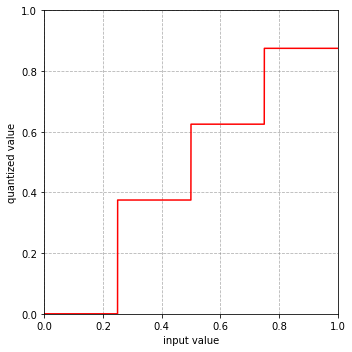

In [4]:
def linearQuantMidVal(data, bits, quant_range=(0.0, 1.0)):
    base = (quant_range[1] - quant_range[0]) / (2.0**bits)
    cutpoints = [quant_range[0]] + [(i+1)*base for i in range(int(2.0**bits))]
    offset_val = (cutpoints[0] + cutpoints[1]) / 2
    res = np.floor(data / base) * base + offset_val
    res[data < cutpoints[1]] = 0.0
    return res

linear_quant_dat = linearQuantMidVal(dat, num_bits)

plt.plot(dat, linear_quant_dat, 'r-')
plt.grid(linestyle='--', color='grey', alpha=0.6)
# plt.xticks(np.arange(0, 1, step=0.1))
# plt.yticks(np.arange(0, 1, step=0.1))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('input value')
plt.ylabel('quantized value')
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.tight_layout()
plt.show()
plt.close()

## Linear quant, linear scale with pruning

[0.0, 0.24975, 0.4995, 0.74925, 0.999]


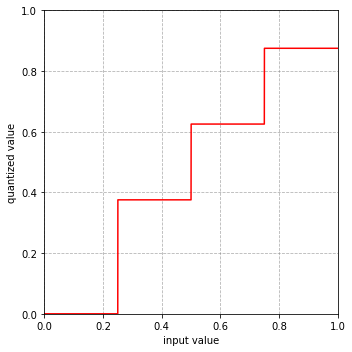

In [2]:
def linearQuantClampedMidVal(att, bits, quant_range=(0.0, 1.0)):
    min_val = 1e-3
    base = (quant_range[1] - min_val) / (2.0**bits)
    cutpoints = [quant_range[0]] + [(i+1)*base for i in range(int(2.0**bits))]
    print(cutpoints)
    offset_val = (cutpoints[0] + cutpoints[1]) / 2
    res = np.floor((att-min_val) / base) * base + offset_val + min_val
    res[att < cutpoints[1]+min_val] = 0.0
    return res

linear_quant_dat = linearQuantClampedMidVal(dat, 2)

plt.plot(dat, linear_quant_dat, 'r-')
plt.grid(linestyle='--', color='grey', alpha=0.6)
# plt.xticks(np.arange(0, 1, step=0.1))
# plt.yticks(np.arange(0, 1, step=0.1))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('input value')
plt.ylabel('quantized value')
fig = plt.gcf()
fig.set_size_inches(5, 5)
plt.tight_layout()
plt.show()
plt.close()

## Linear quant log scale: quantizing on log base, the num_bits affects the minimum value

[1.e-08 1.e-06 1.e-04 1.e-02 1.e+00]


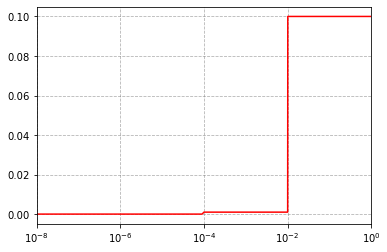

In [11]:
def logQuantMidval(att, bits):
    min_val = 1e-8
    min_exp = log2(min_val)
    base = (0-min_exp) / (2.0**bits)
    cutpoints = np.array([0.0] + [(i+1)*base for i in range(int(2.0**bits))])
    print(2**(min_exp+cutpoints))
    offset_val = (cutpoints[2]-cutpoints[1])/2
    res = np.floor((np.log2(att)-min_exp) / base) * base + offset_val + min_exp
    res[att < 2**(min_exp + cutpoints[1])] = float('-Inf')
    return 2**res

log_quant_dat = logQuantMidval(dat, 2)
fig, ax = plt.subplots()
ax.set_xlim(1e-8,1)
ax.set_xscale('log', basex=10)
# ax.set_yscale('log', basey=10)
# ax.set_ylim(1e-6, 1)
ax.plot(dat, log_quant_dat, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()

## Linear quant log scale with pruning: quantizing only the selecting range evenly on log base.

<ipython-input-3-0f204339c42b>:8: RuntimeWarning: divide by zero encountered in log2
  res = np.floor((np.log2(att)-min_exp) / base) * base + offset_val + min_exp
<ipython-input-3-0f204339c42b>:15: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=10)


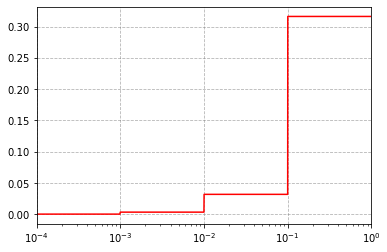

In [3]:
def clampedLogQuantMidval(att, bits):
    min_val = 1e-3
    min_exp = log2(min_val)
    base = (0-min_exp) / (2.0**bits-1)
    cutpoints = np.array([0.0] + [(i+1)*base for i in range(int(2.0**bits-1))])
    offset_val = np.array([(i+j)/2 for i, j in zip(cutpoints[0:-1], cutpoints[1:])])
    offset_val = (cutpoints[0]+cutpoints[1])/2
    res = np.floor((np.log2(att)-min_exp) / base) * base + offset_val + min_exp
    res[att < min_val] = float('-Inf')
    return 2**res

clamped_log_quant_dat = clampedLogQuantMidval(dat, 2)
fig, ax = plt.subplots()
ax.set_xlim(0.0001,1)
ax.set_xscale('log', basex=10)
# ax.set_yscale('log', basey=10)
ax.plot(dat, clamped_log_quant_dat, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()


## Binarization

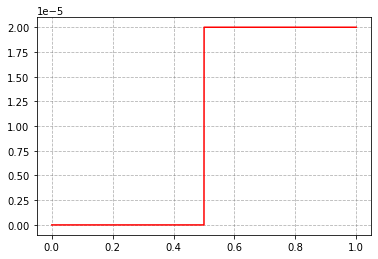

In [20]:
 def binQuant(att, bits):
     thres = 0.5
     res_att = att.copy()
     res_att[att <= thres] = 0.0
     unpruned_elements = float(np.sum(att > thres))
     res_att[att > thres] = 1.0 / unpruned_elements

     return res_att

bin_quant_dat = binQuant(dat, num_bits)
fig, ax = plt.subplots()
# ax.set_xscale('log', basex=2)
ax.plot(dat, bin_quant_dat, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()

## Uniform quant log scale: uniform quantization on the distribution

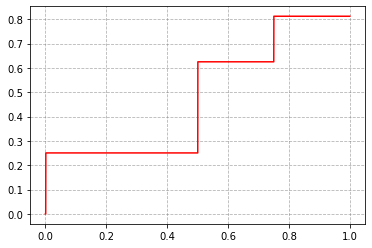

In [3]:
def uniform_slog_clamped_quant(att, bits):
    from math import log
    min_val = 0.001

    att_std = np.copy(att).astype('float64')
    att_std = np.sort(att_std[att_std>min_val])
    num_ranks = int(2.0**bits)
    log_threshs = [min_val,]

    log_steps = np.array([len(att_std)//np.power(2, i) for i in range(1, num_ranks)] + [len(att_std)//np.power(2, num_ranks), ])
    log_steps = np.cumsum(log_steps)[:-1]

    log_threshs += [ att_std[i] for i in log_steps]

    log_steps = np.insert(log_steps, 0, 0.0, axis=0)
    # value_clamp_to = [(start+end)/2.0 for start, end in zip(log_threshs[:-1], log_threshs[1:])]
    value_clamp_to = []
    for start, end in zip(log_steps[:-1], log_steps[1:]):
        value_clamp_to.append(np.mean(att_std[start:end]) if start < end else value_clamp_to[-1])

    value_clamp_to = np.array(value_clamp_to)
    ranking_map = log_threshs[1:]

    if np.isnan(value_clamp_to[-1]): 
        print("break here")

    #zero_mask for vals < 1e-3, compare_done_mask for labelling values that are quantized so far.
    zero_masks, compare_done_mask = np.ones(att.shape), np.ones(att.shape)
    zero_masks[att<min_val] = 0.0
    quant_att = np.zeros(att.shape)
    for thres, val in zip(ranking_map, value_clamp_to):
        quant_att += (att < thres) * val * compare_done_mask
        compare_done_mask = att >= thres

    quant_att += (att < 1.0) * value_clamp_to[-1] * compare_done_mask 
    #^this shouldn't ideally affect anything. Comment it.
    quant_att = quant_att * zero_masks

    return quant_att

uniform_quant_dat = uniform_slog_clamped_quant(dat, 2)
fig, ax = plt.subplots()
# ax.set_xscale('log', basex=10)
ax.plot(dat, uniform_quant_dat, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()

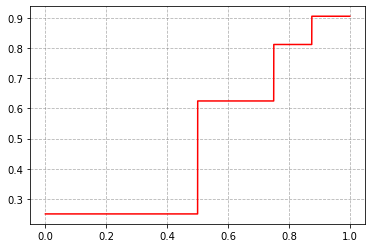

In [12]:
def uniform_slog_quant(att, bits):
    from math import log

    att_std = np.copy(att).astype('float64')
    att_std = np.sort(att_std)
    num_ranks = int(2.0**bits)
    log_threshs = [0.0,]

    log_steps = np.array([len(att_std)//np.power(2, i) for i in range(1, num_ranks+1)] + [len(att_std)//np.power(2, num_ranks), ])
    log_steps = np.cumsum(log_steps)[:-1]

    log_threshs += [ att_std[i] for i in log_steps]

    log_steps = np.insert(log_steps, 0, 0.0, axis=0)
    # value_clamp_to = [(start+end)/2.0 for start, end in zip(log_threshs[:-1], log_threshs[1:])]
    value_clamp_to = []
    for start, end in zip(log_steps[:-1], log_steps[1:]):
        value_clamp_to.append(np.mean(att_std[start:end]) if start < end else value_clamp_to[-1])

    value_clamp_to = np.array(value_clamp_to)
    ranking_map = log_threshs[1:]

    if np.isnan(value_clamp_to[-1]): 
        print("break here")

    # fixed ranking position based on histogram
    compare_done_mask = np.ones(att.shape)
    quant_att = np.zeros(att.shape)
    for thres, val in zip(ranking_map, value_clamp_to):
        quant_att += (att < thres) * val * compare_done_mask
        compare_done_mask = (att >= thres) & (att > 0.0)

    quant_att += (att < 1.0) * value_clamp_to[-1] * compare_done_mask 

    return quant_att

uniform_quant_dat = uniform_slog_quant(dat, 2)
fig, ax = plt.subplots()
# ax.set_xscale('log', basex=10)
ax.plot(dat, uniform_quant_dat, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()

## Quant 8

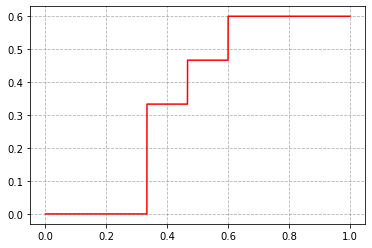

In [33]:
def quant_8_linear(att, bits, min_val, max_val):
    base = (max_val - min_val) / (2**int(bits)-1)
    cutpoints = [0.0] + [(i+1)*base for i in range(int(2.0**bits-1))]
    res = np.floor((att - min_val) / base) * base + min_val
    res[att < (cutpoints[1] + min_val)] = 0
    res[att > max_val] = max_val
    return res

res = quant_8_linear(dat, 2, 0.2, 0.6)
fig, ax = plt.subplots()
# ax.set_xscale('log', basex=10)
ax.plot(dat, res, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()

[0.0, 1.3184026700708402, 2.6368053401416804, 3.9552080102125204, 5.273610680283361, 6.592013350354201, 7.910416020425041, 9.228818690495881]
[       -inf        -inf        -inf ... -0.73696559 -0.73696559
 -0.73696559]
<ipython-input-26-d7c7121e5e3b>:6: RuntimeWarning: divide by zero encountered in log2
  res = np.floor((np.log2(att)-min_exp) / base) * base + min_exp
<ipython-input-26-d7c7121e5e3b>:14: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  ax.set_xscale('log', basex=2)


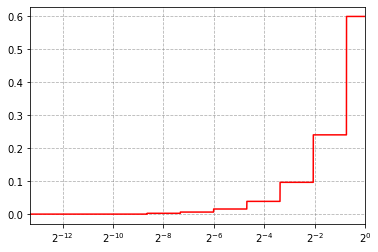

In [26]:
def quant_8_log(att, bits, min_val, max_val):
    min_exp, max_exp = log2(min_val), log2(max_val)
    base = (max_exp-min_exp) / (2.0**bits - 1)
    cutpoints = [0.0] + [(i+1)*base for i in range(int(2.0**bits-1))]
    print(cutpoints)
    res = np.floor((np.log2(att)-min_exp) / base) * base + min_exp
    res[att < 2**(cutpoints[1]+min_exp)] = float('-Inf')
    res[att > max_val] = max_exp
    print(res)
    return 2**res

res = quant_8_log(dat, 3, 0.001, 0.6)
fig, ax = plt.subplots()
ax.set_xscale('log', basex=2)
ax.set_xlim(0.0001, 1)
ax.plot(dat, res, 'r-')
ax.grid(linestyle='--', color='grey', alpha=0.6)
plt.show()
plt.close()